<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/XEASYPermutation_Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis(1) (1).csv')
df2 = df[df['train'] == 1]
print(df2['y'].max())
ymax_train1 = df2['y'].max()
# sve sa train = 0 y = max(y) + 1

for i in range(df.shape[0]):
  if(df.iloc[i]['train'] == 0):
    df.loc[i, 'y'] = ymax_train1 + 1

lower_bound = df['n'] * df['av.length'] / df['m']
lower_bound = lower_bound.astype('int') + 1

upper_bound = np.minimum(df[' LPTUB'], df[' SLACKUB'])
df['rel. bound'] = (upper_bound-lower_bound)/(upper_bound)
df['rel. bound'] = df['rel. bound']*10000

df['category'] = df['y']
for i in range(df.shape[0]):
  #print(df.iloc[i]['y'])
  if(df.iloc[i]['y'] < 1):
    df.loc[i, 'category'] = 0
  elif(df.iloc[i]['y'] >= 1 and df.iloc[i]['y'] < 10):
    df.loc[i, 'category'] = 1
  else:
    df.loc[i, 'category'] = 2

print(df['category'].max())
print(df['y'].max())
df = df[df['y']<1]


shuffled = df.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name', 'CPLEXStatus','type','train', ' LPTUB', ' SLACKUB']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']

X['m/n'] = X['m/n'].apply(lambda x: x*100000)
X['(m/n)^2'] = X['(m/n)^2'].apply(lambda x: x*100000)
X['(m/n)^3'] = X['(m/n)^3'].apply(lambda x: x*100000)
shuffled = shuffled.drop([ 'index'], axis = 1)
print(X.head())

19.907111
2.0
20.907111
   subtype  class  indeks    n   m    n/m   (n/m)^2      (n/m)^3      m/n  \
0        4      4       2   66  24   2.75    7.5625    20.796875  36363.6   
1        4      2      10  154  56   2.75    7.5625    20.796875  36363.6   
2        4      6       1  132  48   2.75    7.5625    20.796875  36363.6   
3       14      1       8  220  20  11.00  121.0000  1331.000000   9090.9   
4        8      4       6  100  25   4.00   16.0000    64.000000  25000.0   

   (m/n)^2  (m/n)^3   av.length     std.dev  median  range  min  max    k  \
0  13223.1   4808.4  100.545456   23.430540    99.0    102   51  153   45   
1  13223.1   4808.4   58.532467   23.308439    59.0     80   20  100   68   
2  13223.1   4808.4  322.590912  113.039886   329.5    393  134  527  114   
3    826.4     75.1   49.645454   28.649696    53.0     98    1   99   85   
4   6250.0   1562.5  100.010002   19.938032   100.0     96   50  146   55   

   rel. bound  category  
0  415.224913       0.0 

In [2]:
from sklearn.preprocessing import StandardScaler

#sc = StandardScaler()
#X = sc.fit_transform(X)

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

regr = RandomForestRegressor(max_depth=20, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, random_state=0)

In [3]:
from sklearn.metrics import mean_squared_error

rmse_full_mod = mean_squared_error(regr.predict(X_test), y_test, squared = False)

results = []

X = pd.DataFrame(X, columns=select)
X_test = pd.DataFrame(X_test, columns=X.columns)

for predictor in X_test:
    #print(predictor)
    X_test_copy = X_test.copy()
    #X_test_copy = X_test_copy.astype('int')
    
    X_test_copy[predictor] = X_test[predictor].sample(frac=1).values
    
    new_rmse = mean_squared_error(regr.predict(X_test_copy), y_test, squared = False)
    
    results.append({'pred': predictor,
                    'score': new_rmse - rmse_full_mod })

resultsdf = pd.DataFrame(results).sort_values(by = 'score', ascending = False)
resultsdf



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

,pred,score
4,m,0.069934
18,rel. bound,0.011470
6,(n/m)^2,0.011001
11,av.length,0.009222
13,median,0.009179
5,n/m,0.009172
12,std.dev,0.008428
0,subtype,0.008291
15,min,0.004824
7,(n/m)^3,0.003208


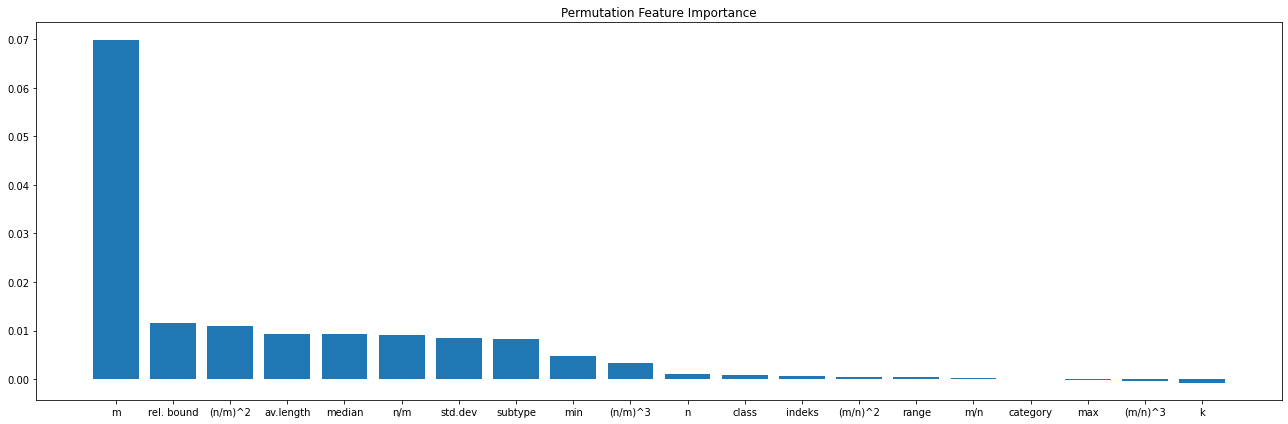

In [4]:
plt.figure(figsize=(18, 6))
plt.title('Permutation Feature Importance')
plt.bar(resultsdf.pred, resultsdf.score)
plt.tight_layout()
plt.show()